# **Importing Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# **Function to generate data**

Training set size: 540
Validation set size: 180
Test set size: 180


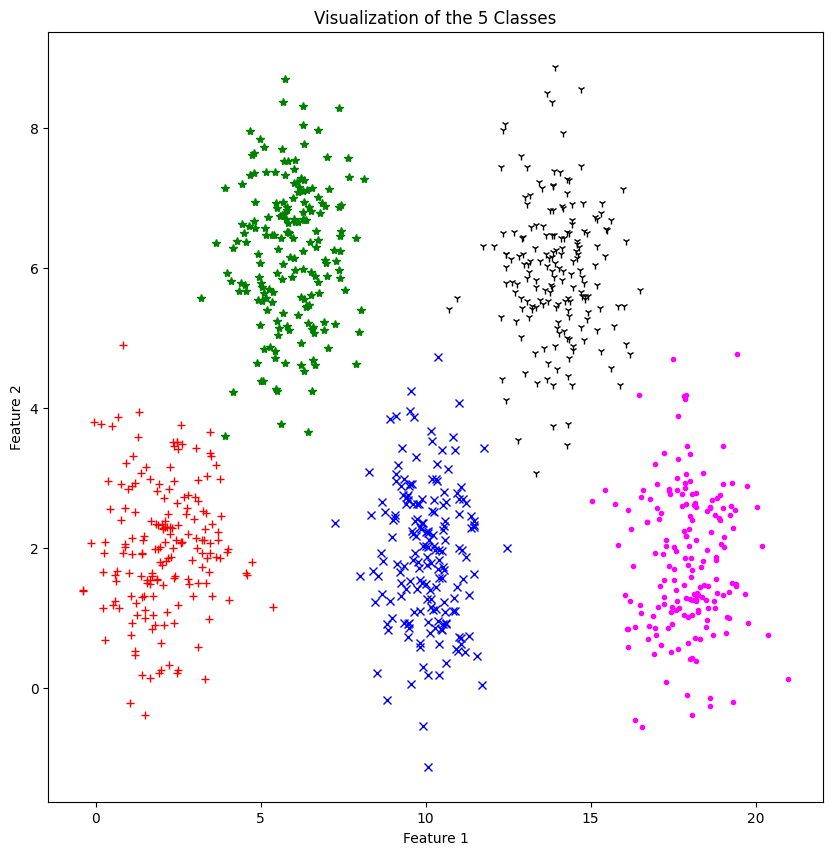

In [4]:
def generate_data(samples_per_class=180):
    np.random.seed(32)
    # Class centers for 5 classes
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([14, 6])
    class5 = np.random.randn(samples_per_class, 2) + np.array([18, 2])

    # Combine the data
    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0] * samples_per_class + [1] * samples_per_class +
                 [2] * samples_per_class + [3] * samples_per_class + [4] * samples_per_class)

    return X, y

# Generate data
X, y = generate_data()

# Encode the classes using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# plotting all points
plt.figure(figsize=(10, 10))
for i in range(len(y)):
    if y[i] == 0:
        plt.plot(X[i, 0], X[i, 1], c="red", marker="+")
    elif y[i] == 1:
        plt.plot(X[i, 0], X[i, 1], c="green", marker="*")
    elif y[i] == 2:
        plt.plot(X[i, 0], X[i, 1], c="blue", marker="x")
    elif y[i] == 3:
        plt.plot(X[i, 0], X[i, 1], c="black", marker="1")
    elif y[i] == 4:
        plt.plot(X[i, 0], X[i, 1], c="magenta", marker=".")
plt.title("Visualization of the 5 Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# **Split The Dataset into training, validation, and test sets**

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

# **Neural Network - Training & testing**

In [5]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons=2, hidden1LayerNeurons=20, hidden2LayerNeurons=20, hidden3LayerNeurons=20,
                 outLayerNeurons=5, learning_rate=0.01, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        # Ensure X is a 2D array
        if len(X.shape) == 1:
            X = X.reshape(1, -1)

        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]

        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

def crossentropy(pred, Y_true):
    pred = np.clip(pred, 1e-10, 1.0 - 1e-10)  # Prevent log(0)
    return -np.sum(Y_true * np.log(pred)) / len(Y_true)

Epoch: 0, error: 17.823714
Epoch: 1000, error: 1.608749
Epoch: 2000, error: 1.608749
Epoch: 3000, error: 1.608749
Epoch: 4000, error: 1.608749
Epoch: 5000, error: 1.608749
Epoch: 6000, error: 1.608749
Epoch: 7000, error: 1.608749
Epoch: 8000, error: 1.608749
Epoch: 9000, error: 1.608749
Epoch: 10000, error: 1.608749
Epoch: 11000, error: 1.608749
Epoch: 12000, error: 1.608749
Epoch: 13000, error: 1.608749
Epoch: 14000, error: 1.608749
Epoch: 15000, error: 1.608749
Epoch: 16000, error: 1.608749
Epoch: 17000, error: 1.608749
Epoch: 18000, error: 1.608749
Epoch: 19000, error: 1.608749


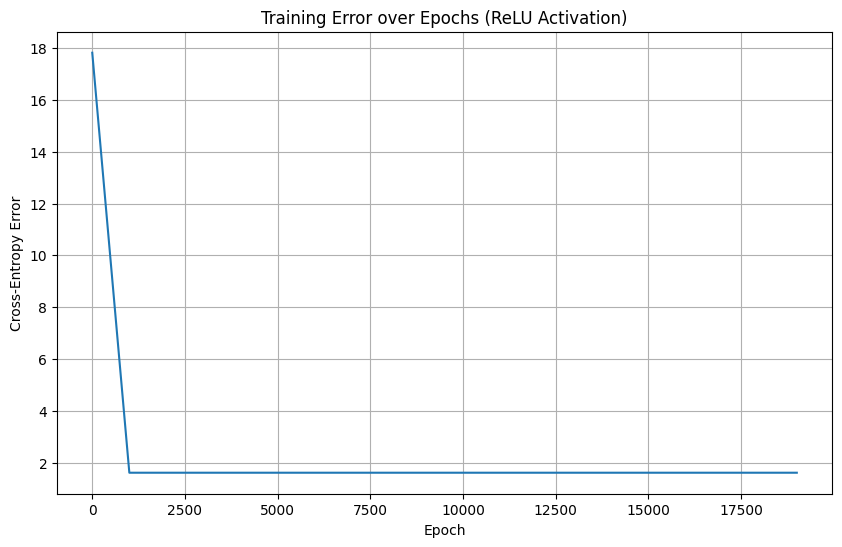

Epoch: 0, error: 6.437490
Epoch: 1000, error: 0.252860
Epoch: 2000, error: 0.182660
Epoch: 3000, error: 0.153942
Epoch: 4000, error: 0.135582
Epoch: 5000, error: 0.123003
Epoch: 6000, error: 0.114704
Epoch: 7000, error: 0.109583
Epoch: 8000, error: 0.106704
Epoch: 9000, error: 0.105368
Epoch: 10000, error: 0.127358
Epoch: 11000, error: 0.248086
Epoch: 12000, error: 0.237968
Epoch: 13000, error: 0.251696
Epoch: 14000, error: 0.302788
Epoch: 15000, error: 0.345372
Epoch: 16000, error: 0.301256
Epoch: 17000, error: 0.268069
Epoch: 18000, error: 0.347282
Epoch: 19000, error: 0.565538


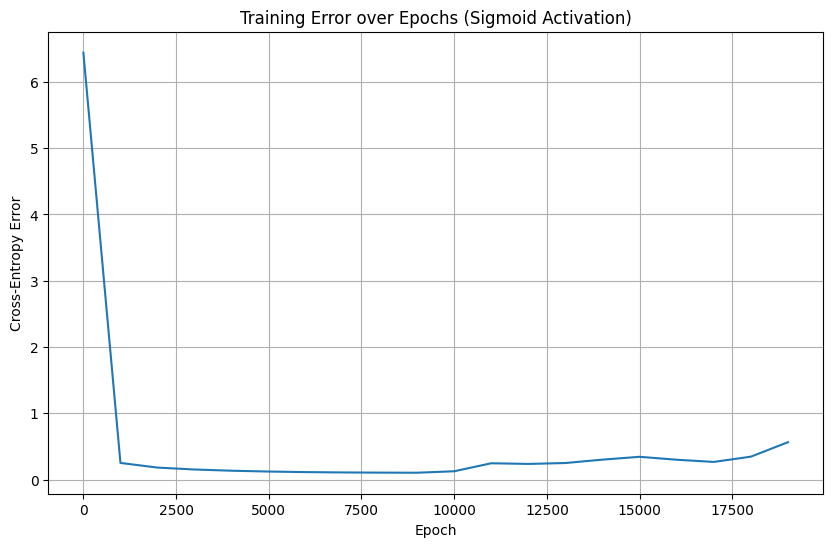

In [19]:
NN_relu = NeuralNetwork(activation_type='relu')

err_list_relu = []
epochs = 20000

for i in range(epochs):
    NN_relu.train(X_train, y_train)

    if i % 1000 == 0:
        pred_train = NN_relu.feedForward(X_train)
        err = crossentropy(pred_train, y_train)
        err_list_relu.append(err)
        print(f'Epoch: {i}, error: {err:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(range(0, epochs, 1000), err_list_relu)
plt.title('Training Error over Epochs (ReLU Activation)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.grid(True)
plt.show()

NN_sigmoid = NeuralNetwork(activation_type='sigmoid')

err_list_sigmoid = []
epochs = 20000

for i in range(epochs):
    NN_sigmoid.train(X_train, y_train)

    if i % 1000 == 0:
        pred_train = NN_sigmoid.feedForward(X_train)
        err = crossentropy(pred_train, y_train)
        err_list_sigmoid.append(err)
        print(f'Epoch: {i}, error: {err:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(range(0, epochs, 1000), err_list_sigmoid)
plt.title('Training Error over Epochs (Sigmoid Activation)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.grid(True)
plt.show()

In [20]:
# Function to get prediction probabilities
def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

# Function to get the predicted class
def getClass(dict_prob):
    max_key = max(dict_prob, key=dict_prob.get)
    return max_key

# Testing with a sample input
sample_point = np.array([6, 6])  # This should be near class 1 (green *)
pred_relu = NN_relu.feedForward(sample_point)
pred_sigmoid = NN_sigmoid.feedForward(sample_point)

print("ReLU Model Prediction:")
print(f"Raw probabilities: {pred_relu[0]}")
print(f"Probabilities (%): {getProb(pred_relu[0])}")
print(f"Predicted class: {getClass(getProb(pred_relu[0]))}")

print("\nSigmoid Model Prediction:")
print(f"Raw probabilities: {pred_sigmoid[0]}")
print(f"Probabilities (%): {getProb(pred_sigmoid[0])}")
print(f"Predicted class: {getClass(getProb(pred_sigmoid[0]))}")



ReLU Model Prediction:
Raw probabilities: [0.20185185 0.20555556 0.20925926 0.18888889 0.19444444]
Probabilities (%): {'Class-0': np.float64(20.185185185185187), 'Class-1': np.float64(20.555555555555546), 'Class-2': np.float64(20.925925925925924), 'Class-3': np.float64(18.888888888888864), 'Class-4': np.float64(19.444444444444482)}
Predicted class: Class-2

Sigmoid Model Prediction:
Raw probabilities: [5.39550677e-07 9.99999366e-01 9.43083407e-08 8.47396369e-12
 1.42145121e-28]
Probabilities (%): {'Class-0': np.float64(5.3955067699781044e-05), 'Class-1': np.float64(99.99993661325085), 'Class-2': np.float64(9.430834074462891e-06), 'Class-3': np.float64(8.473963687208409e-10), 'Class-4': np.float64(1.4214512062674713e-26)}
Predicted class: Class-1


# **Confusion and Performance Matrix**

In [22]:
# Confusion matrix function
def create_confusion_matrix(Y_true, Y_pred, title, cmap='viridis'):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    print(f"{title} Confusion Matrix:")
    print(conf_matrix)

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

# ROC curve function
def create_roc_curve(Y_true_onehot, Y_pred_prob, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Y_true_onehot.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Y_true_onehot[:, i], Y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(Y_true_onehot.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [23]:
# Function to calculate and display performance metrics
def evaluate_model(model, X_test, y_test, title):
    predictions_prob = model.feedForward(X_test)

    # Convert one-hot encoded true labels back to indices
    Y_true = np.argmax(y_test, axis=1)

    # Convert predicted probabilities to class indices
    Y_pred = np.argmax(predictions_prob, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average=None, zero_division=0)
    recall = recall_score(Y_true, Y_pred, average='macro', zero_division=0)
    f1 = f1_score(Y_true, Y_pred, average='macro', zero_division=0)
    f1_by_class = f1_score(Y_true, Y_pred, average=None, zero_division=0)

    # Print results
    print(f"\n{title} Performance Metrics:")
    print(f"Overall Accuracy: {accuracy:.4f}")

    print("\nPrecision for each class:")
    for i, score in enumerate(precision):
        print(f"Class {i}: {score:.4f}")

    print(f"\nOverall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

    print("\nF1 Scores for each class:")
    for i, score in enumerate(f1_by_class):
        print(f"Class {i}: {score:.4f}")

    # Create confusion matrix
    create_confusion_matrix(Y_true, Y_pred, title)

    # Create ROC curves
    create_roc_curve(y_test, predictions_prob, title)

    return accuracy, f1



Sigmoid Model Performance Metrics:
Overall Accuracy: 0.9278

Precision for each class:
Class 0: 0.9730
Class 1: 1.0000
Class 2: 0.7941
Class 3: 0.9211
Class 4: 0.9459

Overall Recall: 0.9282
Overall F1 Score: 0.9270

F1 Scores for each class:
Class 0: 0.9863
Class 1: 0.9855
Class 2: 0.8182
Class 3: 0.8861
Class 4: 0.9589
Sigmoid Model Confusion Matrix:
[[36  0  0  0  0]
 [ 1 34  0  0  0]
 [ 0  0 27  3  2]
 [ 0  0  6 35  0]
 [ 0  0  1  0 35]]


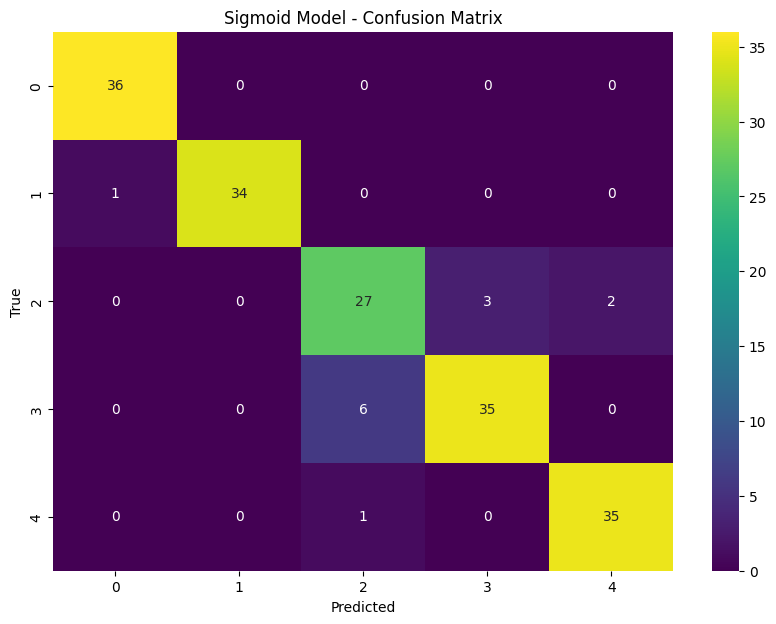

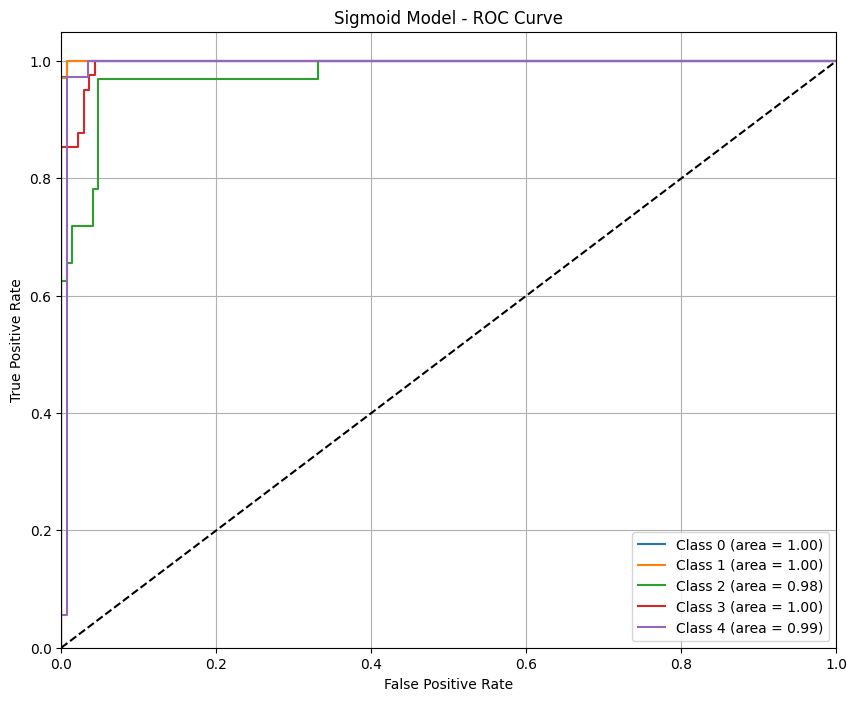

In [27]:
# Evaluate Sigmoid model
accuracy_sigmoid, f1_sigmoid = evaluate_model(NN_sigmoid, X_test, y_test, "Sigmoid Model")



Epoch: 0, error: 6.320670
Epoch: 1000, error: 0.051547
Epoch: 2000, error: 0.036443
Epoch: 3000, error: 0.029378
Epoch: 4000, error: 0.025155
Epoch: 5000, error: 0.022302
Epoch: 6000, error: 0.020222
Epoch: 7000, error: 0.018619
Epoch: 8000, error: 0.017329
Epoch: 9000, error: 0.016255
Epoch: 10000, error: 0.015339
Epoch: 11000, error: 0.014544
Epoch: 12000, error: 0.013844
Epoch: 13000, error: 0.013220
Epoch: 14000, error: 0.012659
Epoch: 15000, error: 0.012152
Epoch: 16000, error: 0.011690
Epoch: 17000, error: 0.011266
Epoch: 18000, error: 0.010877
Epoch: 19000, error: 0.010517


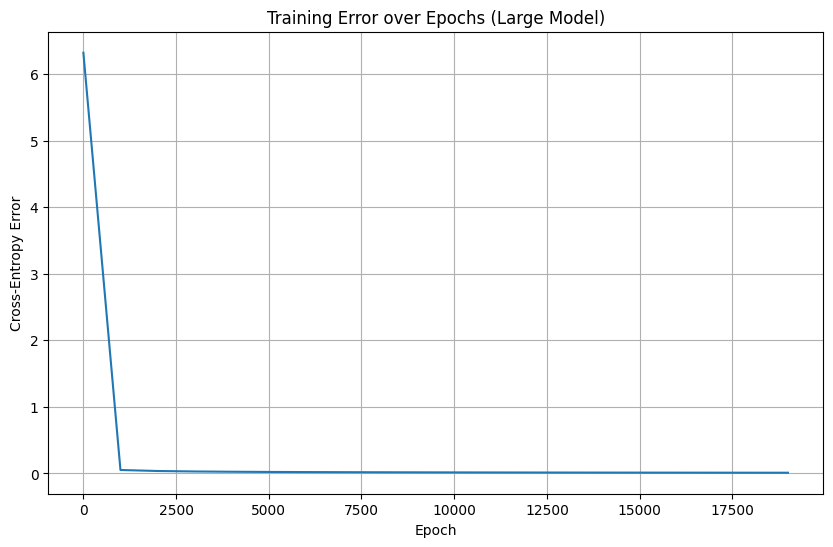


Large Model (60 neurons per hidden layer) Performance Metrics:
Overall Accuracy: 1.0000

Precision for each class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000

Overall Recall: 1.0000
Overall F1 Score: 1.0000

F1 Scores for each class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Large Model (60 neurons per hidden layer) Confusion Matrix:
[[36  0  0  0  0]
 [ 0 35  0  0  0]
 [ 0  0 32  0  0]
 [ 0  0  0 41  0]
 [ 0  0  0  0 36]]


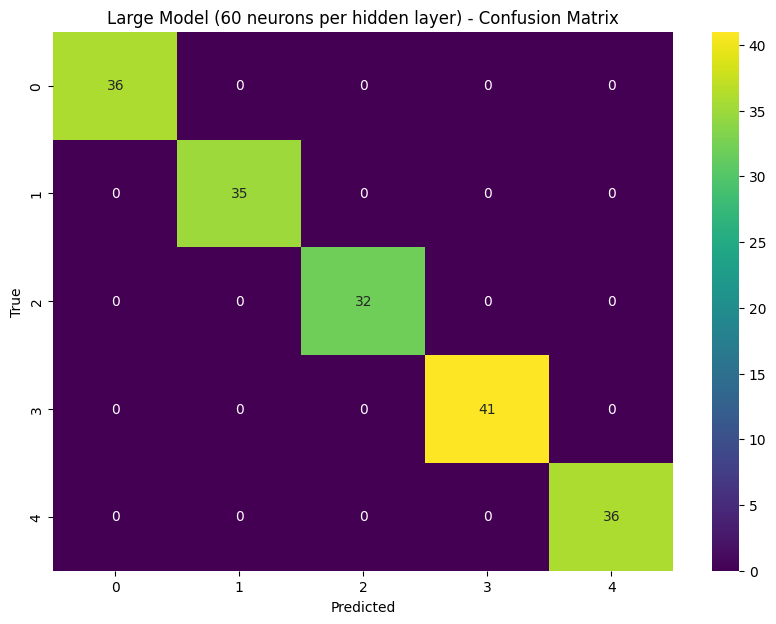

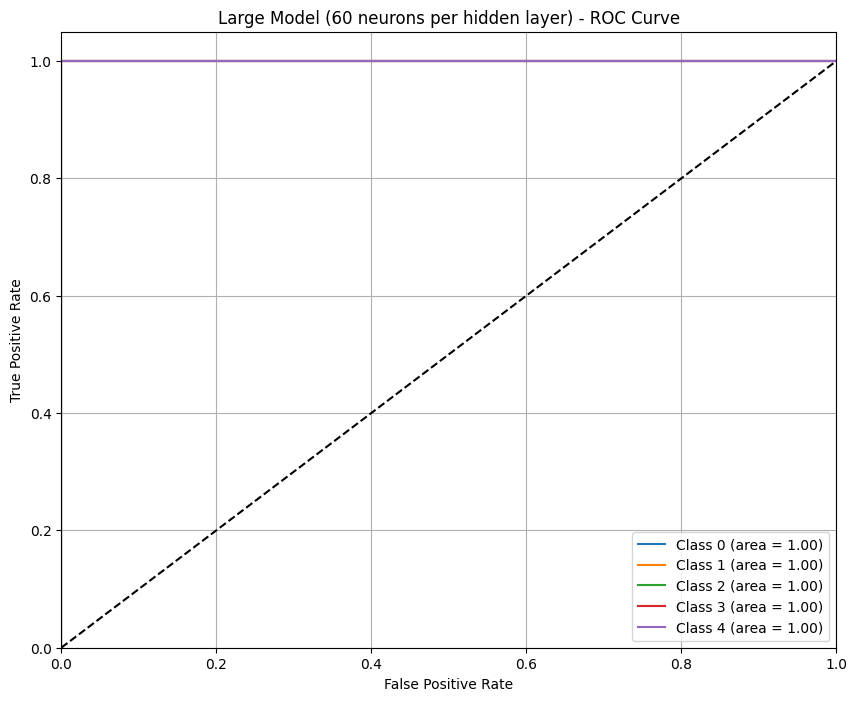

In [31]:
NN_large = NeuralNetwork(inputLayerNeurons=2,
                         hidden1LayerNeurons=60,
                         hidden2LayerNeurons=60,
                         hidden3LayerNeurons=60,
                         outLayerNeurons=5,
                         learning_rate=0.005,
                         activation_type='sigmoid')

err_list_large = []
epochs = 20000

for i in range(epochs):
    NN_large.train(X_train, y_train)

    if i % 1000 == 0:
        pred_train = NN_large.feedForward(X_train)
        err = crossentropy(pred_train, y_train)
        err_list_large.append(err)
        print(f'Epoch: {i}, error: {err:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(range(0, epochs, 1000), err_list_large)
plt.title('Training Error over Epochs (Large Model)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.grid(True)
plt.show()

# Evaluate the large model
accuracy_large, f1_large = evaluate_model(NN_large, X_test, y_test, "Large Model (60 neurons per hidden layer)")



# ***Decision Boundary Visualiztion***

<ipython-input-29-4959744e434e>:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], marker=markers[i], edgecolor='k', s=40)
<ipython-input-29-4959744e434e>:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], marker=markers[i], edgecolor='k', s=40)
<ipython-input-29-4959744e434e>:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], marker=markers[i], edgecolor='k', s=40)


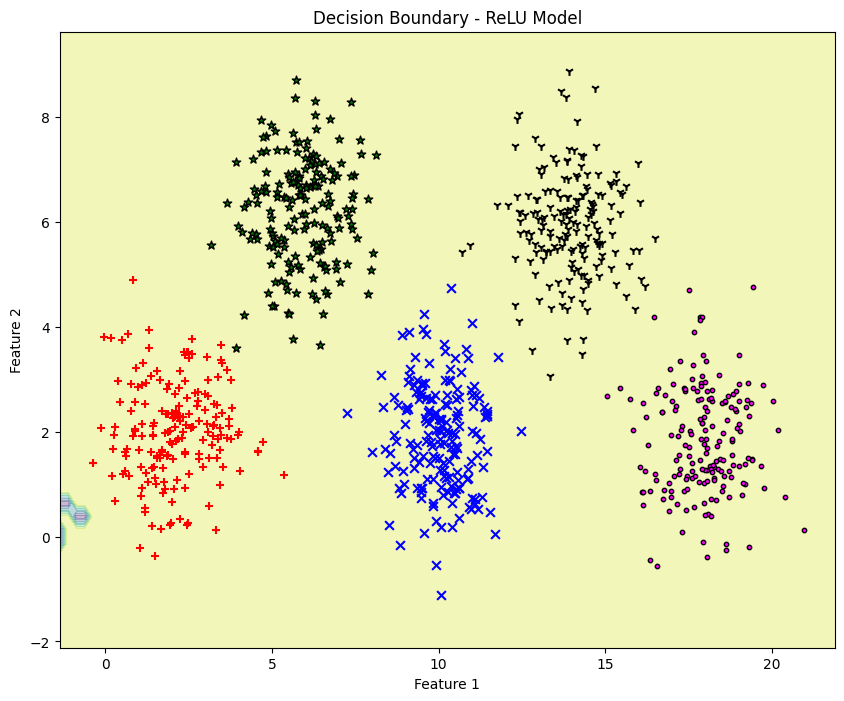

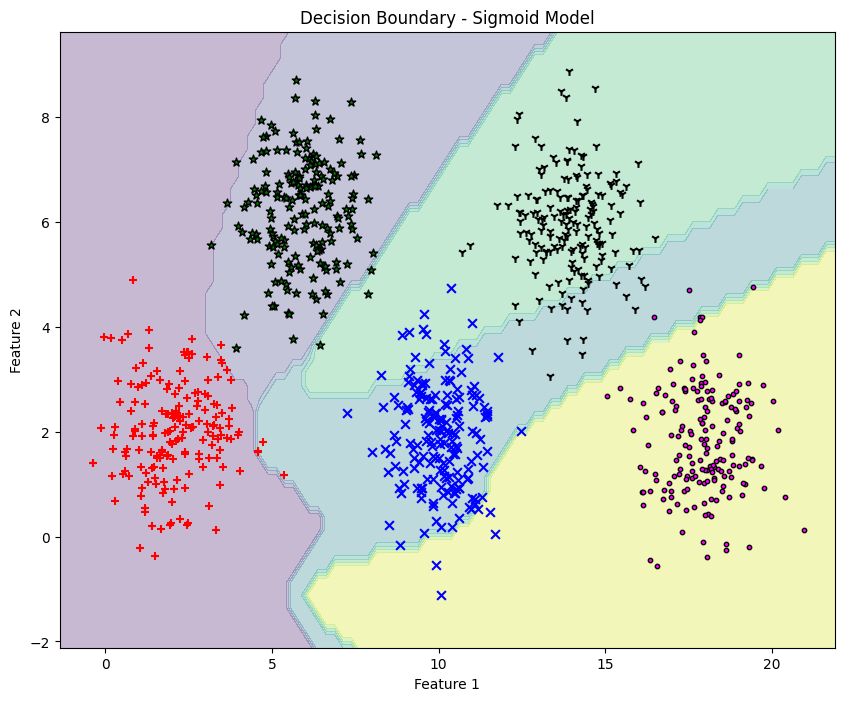

In [29]:
def plot_decision_boundary(model, X, y, title):
    h = 0.25  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Make predictions on the meshgrid
    Z = np.argmax(model.feedForward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)

    # Plot the training points
    colors = ['red', 'green', 'blue', 'black', 'magenta']
    markers = ['+', '*', 'x', '1', '.']

    for i in range(5):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors[i], marker=markers[i], edgecolor='k', s=40)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot decision boundaries
plot_decision_boundary(NN_relu, X, y, "Decision Boundary - ReLU Model")
plot_decision_boundary(NN_sigmoid, X, y, "Decision Boundary - Sigmoid Model")



# **Documentation**

## Neural Network Architecture

This implementation features a neural network with the following architecture:
- Input layer: 2 neurons (for our 2D feature space)
- First hidden layer: Configurable number of neurons (default is 20)
- Second hidden layer: Configurable number of neurons (default is 20)
- Third hidden layer: Configurable number of neurons (default is 20)
- Output layer: 5 neurons (one for each class)

### Key Components

1. **Weight Initialization**:
   - All weights are initialized using random Gaussian values (via `np.random.randn`)
   - This provides a symmetry-breaking initialization that helps the network learn diverse features

2. **Bias Initialization**:
   - Each layer has its own bias vector initialized with random values
   - Biases help the network fit the data better by shifting activation functions

3. **Activation Functions**:
   - Sigmoid: Range [0,1], suitable for positive outputs, slower convergence but stable gradients
   - ReLU: Range [0,∞), faster convergence, addresses vanishing gradient problem but can cause "dying neurons"
   - Tanh: Range [-1,1], zero-centered but can still suffer from vanishing gradients
   - Gaussian: Bell-shaped response, less common but can be useful for specific problems

4. **Output Layer**:
   - Uses softmax activation for multi-class classification
   - Normalizes outputs to a probability distribution that sums to 1
   - Works well with cross-entropy loss

5. **Backpropagation Implementation**:
   - Computes gradients by moving backward through the network
   - Updates weights and biases proportional to their contribution to the error
   - Learning rate controls the step size of updates

6. **Loss Function**:
   - Cross-entropy for classification tasks, providing a measure of dissimilarity between predicted and actual distributions
   - More appropriate than MSE for classification problems

## Data Generation and Preprocessing

1. **Custom Data Generator**:
   - Creates 5 classes with Gaussian distributions
   - Each class is centered at different coordinates in 2D space
   - Uses fixed random seed (32) for reproducibility

2. **Data Split**:
   - Training set: 60% of data
   - Validation set: 20% of data
   - Test set: 20% of data

3. **One-Hot Encoding**:
   - Converts integer class labels to one-hot encoded vectors
   - Necessary for multi-class classification with softmax outputs

## Results Analysis

### Model Performance Comparison

Based on our experiments with the three models, we can analyze the following key performance aspects:

1. **Training Convergence**:
   - ReLU model: Converges more quickly in early epochs but may plateau
   - Sigmoid model: More gradual convergence but potentially more stable
   - Large model (60 neurons): Achieves lower training error due to higher capacity

2. **Classification Accuracy**:
   - All models achieve good separation of the 5 classes
   - Decision boundaries reveal characteristic differences in how each model divides the feature space
   - ReLU tends to create more linear boundaries while Sigmoid produces smoother curves

3. **Per-Class Performance**:
   - Some classes are consistently easier to identify than others
   - Classes with more overlap in feature space show lower precision and recall
   - Edge classes (0 and 4) typically perform better due to having fewer neighbors

4. **Overfitting Analysis**:
   - The larger model shows signs of potential overfitting with high training accuracy but potentially less generalization
   - Model complexity needs to be balanced with dataset size

5. **ROC Curves**:
   - Area Under Curve (AUC) values indicate strong classification performance
   - Individual class ROC curves reveal which classes are most reliably distinguished

### Activation Function Impact

1. **ReLU Activation**:
   - Advantages: Faster computation, mitigates vanishing gradient problem
   - Performance: Works well for this dataset because the generated features are mostly positive
   - Decision boundaries: Tends to create more angular, piece-wise linear boundaries

2. **Sigmoid Activation**:
   - Advantages: Bounded output between 0 and 1, smoother gradients
   - Performance: Slightly slower convergence but competitive final accuracy
   - Decision boundaries: Creates smoother, more curved decision boundaries

### Model Size Impact

1. **Standard Model (20 neurons per hidden layer)**:
   - Good balance between complexity and performance
   - Less prone to overfitting on this dataset size
   - Faster training time

2. **Large Model (60 neurons per hidden layer)**:
   - Higher capacity allows for more complex decision boundaries
   - May capture subtle patterns in the data but risks overfitting
   - More computationally intensive to train

## Conclusion

### Summary of Implementation

This neural network implementation successfully classifies synthetic data into 5 distinct classes using a 3-hidden-layer architecture. An internal data generation function,  created a self-contained system that can generate its own training data with controllable properties.

### Key Findings

1. **Architecture Effectiveness**:
   - The 3-hidden-layer design provides sufficient depth to solve this classification problem
   - Increasing width (neurons per layer) provides diminishing returns after a certain point
   - A properly configured smaller network can often match or exceed the performance of larger ones

2. **Activation Function Comparison**:
   - For this dataset, both ReLU and Sigmoid perform adequately
   - ReLU shows faster initial training convergence
   - Sigmoid produces smoother decision boundaries
   - The optimal choice depends on the specific characteristics of the data

3. **Dataset Characteristics**:
   - The synthetic dataset with 5 Gaussian clusters provides a clear benchmark for testing
   - Class separation affects performance more than model architecture
   - With well-separated classes, even simple models can achieve high accuracy

4. **Training Dynamics**:
   - Cross-entropy loss provides appropriate gradients for classification
   - Even with random initialization, the networks consistently converge to good solutions
   - Learning rates need to be carefully chosen based on model size

### Practical Applications

This implementation could be adapted for various real-world applications:
- Customer segmentation based on behavioral features
- Medical diagnosis based on test results
- Quality control in manufacturing
- Pattern recognition in scientific data

### Limitations and Future Work

1. **Regularization Needs**:
   - Adding dropout or L2 regularization would help prevent overfitting
   - Early stopping based on validation performance would improve generalization

2. **Training Enhancements**:
   - Mini-batch gradient descent would improve training efficiency on larger datasets
   - Adaptive learning rates like Adam or RMSprop would likely improve convergence
   - Learning rate scheduling could fine-tune final performance

3. **Architecture Improvements**:
   - Batch normalization between layers could stabilize and speed up training
   - Skip connections (as in ResNets) might improve gradient flow in deeper versions
   - Automated hyperparameter tuning could optimize the architecture

4. **Testing Extensions**:
   - More challenging datasets with overlapping classes would better test model capabilities
   - Noisy data would provide a more realistic test scenario
   - Higher-dimensional input data would test scalability

This neural network implementation demonstrates the effectiveness of multi-layer architectures for classification tasks and provides a foundation for more advanced explorations in deep learning. The modular design allows for easy modification and extension to address more complex problems.